In [3]:
if 'sc' not in locals():
    from pyspark.context import SparkContext
    from pyspark.sql.context import SQLContext
    from pyspark.sql.session import SparkSession
    
    sc = SparkContext()
    sqlContext = SQLContext(sc)
    spark = SparkSession(sc)

File Name                                             Modified             Size
fake.csv                                       2019-09-20 02:14:32     56680002


Columns
Fake:
Index(['uuid', 'ord_in_thread', 'author', 'published', 'title', 'text',
       'language', 'crawled', 'site_url', 'country', 'domain_rank',
       'thread_title', 'spam_score', 'main_img_url', 'replies_count',
       'participants_count', 'likes', 'comments', 'shares', 'type'],
      dtype='object')
bs            11492
bias            443
conspiracy      430
hate            246
satire          146
state           121
junksci         102
fake             19
Name: type, dtype: int64


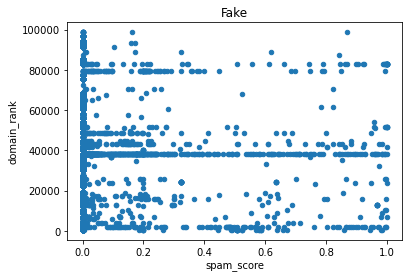

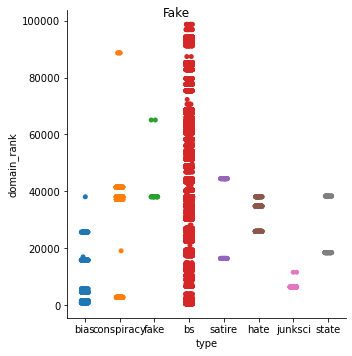

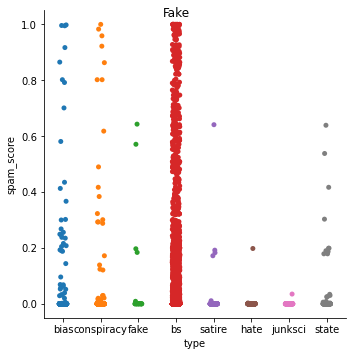

In [4]:
%run 'Load & Clean Fake'.ipynb

In [5]:
fake_df.head()

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,replies_count,participants_count,likes,comments,shares,type
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,0,1,0,0,0,bias
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,0,1,0,0,0,bias
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,0,1,0,0,0,bias
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,0,0,0,0,0,bias
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,0,0,0,0,0,bias


In [6]:
fake_df = fake_df.drop('uuid', axis=1)
fake_df = fake_df.drop('published', axis=1)
fake_df = fake_df.drop('title', axis=1)
fake_df = fake_df.drop('text', axis=1)
fake_df = fake_df.drop('crawled', axis=1)
fake_df = fake_df.drop('thread_title', axis=1)

In [7]:
authors_filtered = fake_df.author.value_counts()[fake_df.author.value_counts() <= 13].index
fake_df.author = fake_df.author.replace(authors_filtered, 'uncommon_author')

site_filtered = fake_df.site_url.value_counts()[fake_df.site_url.value_counts() <= 15].index
fake_df.site_url = fake_df.site_url.replace(site_filtered, 'uncommon_site')

fake_df.site_url = fake_df.site_url.str.lower
fake_df.site_url = fake_df.site_url.str.strip()

fake_df.author = fake_df.author.str.lower
fake_df.author = fake_df.author.str.strip()

fake_df = p.get_dummies(data=fake_df, columns=['language', 'country', 'site_url', 'author'])

fake_df.type = fake_df.type.astype('category').cat.codes

In [8]:
print(fake_df.shape)

(12999, 50)


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
     fake_df, fake_df['type'],
    test_size=0.33, random_state=42)

In [11]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=X_train.columns.drop('type').values,outputCol="features")
spDF_train = assembler.transform(sqlContext.createDataFrame(X_train))
spDF_test = assembler.transform(sqlContext.createDataFrame(X_test))

In [12]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


dt = DecisionTreeClassifier(featuresCol="features", labelCol="type")

paramGrid = ParamGridBuilder().addGrid(dt.maxDepth, [1,3,5,7]) \
                            .addGrid(dt.maxBins, [20, 50, 100, 200]) \
                            .addGrid(dt.minInstancesPerNode, [2, 5, 8, 15]).build()

crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="type", predictionCol="prediction", metricName="f1"),
                          numFolds=10)

cvModel = crossval.fit(spDF_train)

In [13]:
prediction = cvModel.transform(spDF_test)
MulticlassClassificationEvaluator(labelCol="type", predictionCol="prediction", metricName="f1").evaluate(prediction)

0.9395607604295623

In [94]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features", labelCol="type")

rf_paramGrid = ParamGridBuilder().addGrid(rf.maxDepth, [1,3,5,7]) \
                            .addGrid(rf.maxBins, [20, 50, 100, 200]) \
                            .addGrid(rf.numTrees, [2,5,10,25]) \
                            .addGrid(rf.minInstancesPerNode, [2, 5, 8, 15]).build()

rf_crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=rf_paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="type", predictionCol="prediction", metricName="f1"),
                          numFolds=10)

rf_cvModel = crossval.fit(spDF_train)

In [95]:
rf_prediction = rf_cvModel.transform(spDF_test)
MulticlassClassificationEvaluator(labelCol="type", predictionCol="prediction", metricName="f1").evaluate(rf_prediction)

0.9375910253663079

In [ ]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(featuresCol="features", labelCol="type")

gbt_paramGrid = ParamGridBuilder().addGrid(gbt.maxDepth, [1,3,5,7]) \
                            .addGrid(gbt.maxBins, [20, 50, 100, 200]) \
                            .addGrid(gbt.minInstancesPerNode, [2, 5, 8, 15]).build()

gbt_crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=gbt_paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="type", predictionCol="prediction", metricName="r2"),
                          numFolds=10)

gbt_cvModel = crossval.fit(spDF_train)

In [ ]:
gbt_prediction = gbt_cvModel.transform(spDF_test)
MulticlassClassificationEvaluator(labelCol="score", predictionCol="prediction", metricName="r2").evaluate(gbt_prediction)